### Case Study: High-Dimensional Product Function  
To validate the proposed RS-HDMR method for estimating Sobol indices and Shapley effects, we apply it to the product function studied by Owen [1], a benchmark designed to stress-test sensitivity estimators in high-dimensional settings. The function is defined as:  

$$
f(\mathbf{x}) = \prod_{j=1}^{d} \left( \mu_j + \tau_j g_j(x_j) \right), \quad x_j \in [0, 1],
$$  

where $g_j(x_j) = \sqrt{12}(x_j - 1/2)$ ensures zero mean and unit variance, $\mu_j = 1$ for all $j$, and $\tau_j = (4, 4, 2, 2, 1, 1)/4$ for $d = 6$. This configuration creates a hierarchy of variable importance, with diminishing contributions from inputs $x_1$ to $x_6$, and analytically tractable Sobol indices given by $\sigma_u^2 = \prod_{j \in u} \tau_j^2 \prod_{j \notin u} \mu_j^2$.  

What makes this function interesting is that the first and second order partial functions of the HDMR decomposition capture only about 83% of the total variance with most of the residual ~17% being accounted for by third and fourth order terms.

---
[1] Owen, Art B. 2013. ‘Better Estimation of Small Sobol’ Sensitivity Indices’. ACM Transactions on Modeling and Computer Simulation 23 (2): 1–17. https://doi.org/10.1145/2457459.2457460.

In [1]:
# Import dependencies
import pandas as pd
import numpy as np

import math

from scipy.spatial import distance 
from shapleyx import rshdmr

from scipy.stats import qmc 

import matplotlib.pyplot as plt

from itertools import combinations

from importlib.metadata import version
print(f"Running on ShapleyX v{version('shapleyx')}")



Running on ShapleyX v0.2


##### Helper functions for building quasi-random sample from the Product Function
Using Sobol sequence sampling with LMS+shift scrambling

In [2]:
def get_column_labels(num_columns):
    return [f'X{i+1}' for i in range(num_columns)]

def owen(m, d, tau_values, mu_values):
    num_dimensions = d
    tau_values = [1, 1, 0.5, 0.5, 0.25, 0.25]
    mu_values = [1, 1, 1, 1, 1, 1]
    
    num_samples = 2**m
    sampler = qmc.Sobol(d, scramble=True, seed=123)
    samples = sampler.random_base2(m)
    
    # Initialize Y with ones and compute product
    Y = np.ones(num_samples)
    for dim in range(num_dimensions):
        g = np.sqrt(12) * (samples[:, dim] - 0.5)
        Y *= (mu_values[dim] + tau_values[dim] * g)
    
    data = pd.DataFrame(samples, columns=get_column_labels(num_dimensions))
    data['Y'] = Y
    return data


##### Using the helper functions, build a dataframe of samples of a designate size
The number of samples in the controlled by m where the number of samples is $2^m$. \
The number of variables, $d$ has to be defined as well as the value of $\tau_j$ and $\mu_j$

In [3]:
# m = 8 -> 256 samples
# m = 9 -> 512 samples
# m = 10 -> 1024 samples
# m = 11 -> 2048 samples 
# m = 12 -> 4096 samples
# m = 13 -> 8192 samples

m=8
d = 6
tau = [1, 1, 0.5, 0.5, 0.25, 0.25]
mu = [1, 1, 1, 1, 1, 1]


dataframe = owen(m, d, tau, mu)
print(len(dataframe), 'samples generated')

256 samples generated


Found a DataFrame

Transforming data to unit hypercube

Feature: X1, Min Value: 0.0036, Max Value: 0.9980
Feature: X2, Min Value: 0.0037, Max Value: 0.9969
Feature: X3, Min Value: 0.0020, Max Value: 0.9983
Feature: X4, Min Value: 0.0013, Max Value: 0.9995
Feature: X5, Min Value: 0.0030, Max Value: 0.9968
Feature: X6, Min Value: 0.0031, Max Value: 0.9999

Building basis functions

Basis functions of 1 order : 48
Basis functions of 2 order : 540
Basis functions of 3 order : 1280
Basis functions of 4 order : 3840
Total basis functions in basis set : 5708
Total number of features in basis set is 5708

Running regression analysis

running ARD
Iteration: 0     Mean CV Score: 0.2141, Percentage Change: inf%
Iteration: 1     Mean CV Score: 0.3470, Percentage Change: 62.09%
Iteration: 2     Mean CV Score: 0.3923, Percentage Change: 13.05%
Iteration: 3     Mean CV Score: 0.4339, Percentage Change: 10.61%
Iteration: 4     Mean CV Score: 0.4671, Percentage Change: 7.65%
Iteration: 5     Mean CV Sc

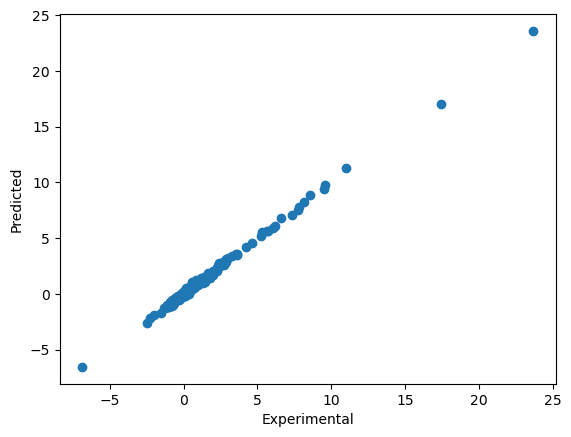


Running bootstrap resampling 1000 samples for 95.0% CI

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 

Completed bootstrap resampling


                  Completed all analysis
                 ------------------------

Miracles come in moments. Be ready and willing.  Wayne
Dyer



In [4]:
model = rshdmr(dataframe,
               polys = [8, 6, 4, 4], 
               n_iter = 100,
#               verbose=True,
               method = 'ard_cv',
               cv_tol=0.005
              )
               
sob, shap, total = model.run_all() 

In [5]:
def powerset(input_list):
    """Return all non-empty members of the powerset."""
    all_combinations = []
    for r in range(1, len(input_list) + 1):  # Start at 1 instead of 0
        all_combinations.extend(
            [list(comb) for comb in combinations(input_list, r)]
        )
    return all_combinations

def sigma_u_squared(u, tau, mu):
    product_tau = math.prod(tau[j]**2 for j in u)
    n = len(tau)
    product_mu = math.prod(mu[j]**2 for j in range(n) if j not in u)
    return product_tau * product_mu


In [6]:
shapleys = [0] * 6
myset = list(range(6)) 
total_var = 0

my_powerset = powerset(myset)
for subset in my_powerset:
    sig_squared = sigma_u_squared(subset, tau, mu)
#    print(f"Subset: {subset}, Sigma_u^2: {sig_squared}")
    for i in subset:
        shapleys[i] += sig_squared / len(subset)
        total_var += sig_squared / len(subset)

shap['analytical'] = np.array(shapleys)/total_var

In [7]:
df = pd.DataFrame()
df['Category'] = shap['label']
df['Value1'] = shap['scaled effect']
df['Value2'] = shap['analytical']
df['Lower'] = shap['lower']
df['Upper'] = shap['upper']

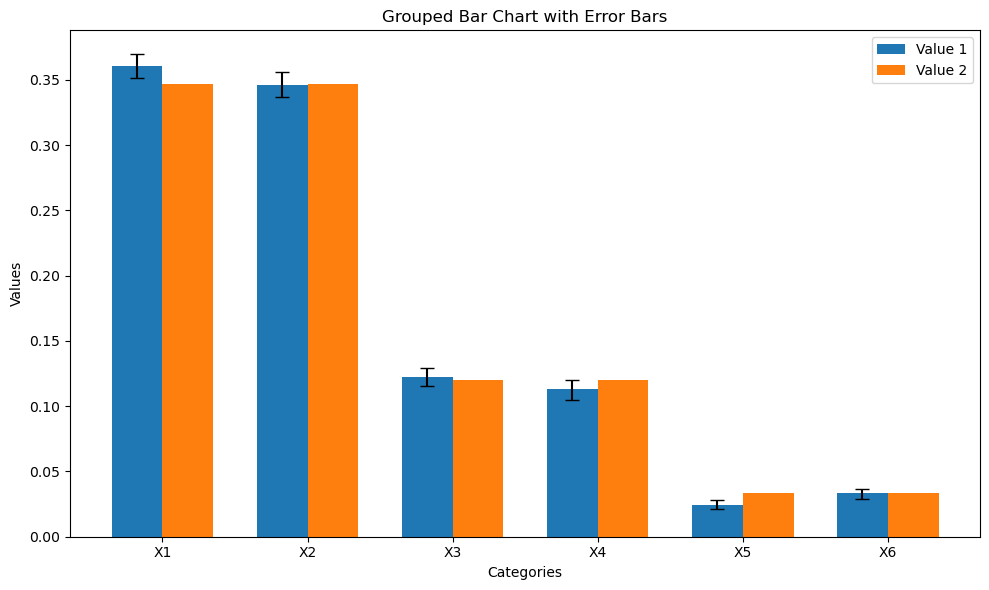

In [8]:


# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Set the width of each bar
bar_width = 0.35

# Positions of the bars on the x-axis
x = np.arange(len(df['Category']))

# Plot the bars
bars1 = ax.bar(x - bar_width/2, df['Value1'], bar_width, 
               label='Value 1', yerr=[df['Value1']-df['Lower'], df['Upper']-df['Value1']],
               capsize=5)

bars2 = ax.bar(x + bar_width/2, df['Value2'], bar_width, 
               label='Value 2')

# Add labels, title, and legend
ax.set_xlabel('Categories')
ax.set_ylabel('Values')
ax.set_title('Grouped Bar Chart with Error Bars')
ax.set_xticks(x)
ax.set_xticklabels(df['Category'])
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [9]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Apr 08 2025

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

pandas    : 2.2.2
matplotlib: 3.8.4
shapleyx  : 0.2
numpy     : 1.26.4
__main__  : <function version at 0x000001F5736DEF20>
scipy     : 1.12.0

Watermark: 2.5.0

